<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 822, '日付': '2021-07-09T08:00:00.000Z'},
 {'小計': 950, '日付': '2021-07-10T08:00:00.000Z'},
 {'小計': 614, '日付': '2021-07-11T08:00:00.000Z'},
 {'小計': 502, '日付': '2021-07-12T08:00:00.000Z'},
 {'小計': 830, '日付': '2021-07-13T08:00:00.000Z'},
 {'小計': 1149, '日付': '2021-07-14T08:00:00.000Z'},
 {'小計': 1308, '日付': '2021-07-15T08:00:00.000Z'},
 {'小計': 1271, '日付': '2021-07-16T08:00:00.000Z'},
 {'小計': 1410, '日付': '2021-07-17T08:00:00.000Z'},
 {'小計': 1008, '日付': '2021-07-18T08:00:00.000Z'},
 {'小計': 727, '日付': '2021-07-19T08:00:00.000Z'},
 {'小計': 1387, '日付': '2021-07-20T08:00:00.000Z'},
 {'小計': 1832, '日付': '2021-07-21T08:00:00.000Z'},
 {'小計': 1979, '日付': '2021-07-22T08:00:00.000Z'},
 {'小計': 1359, '日付': '2021-07-23T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2021-07-19 17:00:00+09:00,603,0,727,2021-07-19 17:00:00+09:00
2021-07-20 17:00:00+09:00,583,0,1387,2021-07-20 17:00:00+09:00
2021-07-21 17:00:00+09:00,724,0,1832,2021-07-21 17:00:00+09:00
2021-07-22 17:00:00+09:00,907,0,1979,2021-07-22 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2021-07-19 17:00:00+09:00,603,0,727,2021-07-19 17:00:00+09:00,577.857143,4045.0,0.0,0.0,1100.428571,7703.0
2021-07-20 17:00:00+09:00,583,0,1387,2021-07-20 17:00:00+09:00,587.142857,4110.0,0.0,0.0,1180.000000,8260.0
2021-07-21 17:00:00+09:00,724,0,1832,2021-07-21 17:00:00+09:00,614.428571,4301.0,0.0,0.0,1277.571429,8943.0
2021-07-22 17:00:00+09:00,907,0,1979,2021-07-22 17:00:00+09:00,664.142857,4649.0,0.0,0.0,1373.428571,9614.0
2021-07-23 17:00:00+09:00,0,0,1359,2021-07-23 17:00:00+09:00,579.142857,4054.0,0.0,0.0,1386.000000,9702.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2021-07-09 17:00:00+09:00,504,0,822,2021-07-09 17:00:00+09:00,436.142857,3053.0,0.0,0.0,686.714286,4807.0,'21w27,Fri
2021-07-10 17:00:00+09:00,502,0,950,2021-07-10 17:00:00+09:00,446.428571,3125.0,0.0,0.0,720.142857,5041.0,'21w27,Sat
2021-07-11 17:00:00+09:00,403,0,614,2021-07-11 17:00:00+09:00,453.285714,3173.0,0.0,0.0,733.857143,5137.0,'21w27,Sun
2021-07-12 17:00:00+09:00,509,0,502,2021-07-12 17:00:00+09:00,468.857143,3282.0,0.0,0.0,756.714286,5297.0,'21w28,Mon
2021-07-13 17:00:00+09:00,518,0,830,2021-07-13 17:00:00+09:00,480.571429,3364.0,0.0,0.0,790.571429,5534.0,'21w28,Tue
2021-07-14 17:00:00+09:00,533,0,1149,2021-07-14 17:00:00+09:00,486.142857,3403.0,0.0,0.0,823.285714,5763.0,'21w28,Wed
2021-07-15 17:00:00+09:00,559,0,1308,2021-07-15 17:00:00+09:00,504.000000,3528.0,0.0,0.0,882.142857,6175.0,'21w28,Thu
2021-07-16 17:00:00+09:00,595,0,1271,2021-07-16 17:00:00+09:00,517.000000,3619.0,0.0,0.0,946.285714,6624.0,'21w28,Fri
2021-07-17 17:00:00+09:00,711,0,1410,2021-07-17 17:00:00+09:00,546.857143,3828.0,0.0,0.0,1012.000000,7084.0,'21w28,Sat
2021-07-18 17:00:00+09:00,526,0,1008,2021-07-18 17:00:00+09:00,564.428571,3951.0,0.0,0.0,1068.285714,7478.0,'21w28,Sun


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2021-07-04 17:00:00+09:00,582.000000,4074
2021-07-11 17:00:00+09:00,733.857143,5137
2021-07-18 17:00:00+09:00,1068.285714,7478
2021-07-23 17:00:00+09:00,1456.800000,7284
2021-01-03 17:00:00+09:00,816.000000,2448


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2021-07-09 17:00:00+09:00,504,0,822,2021-07-09 17:00:00+09:00,436.142857,3053.0,0.0,0.0,686.714286,4807.0,'21w27,Fri,NaN,NaN
2021-07-10 17:00:00+09:00,502,0,950,2021-07-10 17:00:00+09:00,446.428571,3125.0,0.0,0.0,720.142857,5041.0,'21w27,Sat,NaN,NaN
2021-07-11 17:00:00+09:00,403,0,614,2021-07-11 17:00:00+09:00,453.285714,3173.0,0.0,0.0,733.857143,5137.0,'21w27,Sun,733.857143,5137.0
2021-07-12 17:00:00+09:00,509,0,502,2021-07-12 17:00:00+09:00,468.857143,3282.0,0.0,0.0,756.714286,5297.0,'21w28,Mon,NaN,NaN
2021-07-13 17:00:00+09:00,518,0,830,2021-07-13 17:00:00+09:00,480.571429,3364.0,0.0,0.0,790.571429,5534.0,'21w28,Tue,NaN,NaN
2021-07-14 17:00:00+09:00,533,0,1149,2021-07-14 17:00:00+09:00,486.142857,3403.0,0.0,0.0,823.285714,5763.0,'21w28,Wed,NaN,NaN
2021-07-15 17:00:00+09:00,559,0,1308,2021-07-15 17:00:00+09:00,504.000000,3528.0,0.0,0.0,882.142857,6175.0,'21w28,Thu,NaN,NaN
2021-07-16 17:00:00+09:00,595,0,1271,2021-07-16 17:00:00+09:00,517.000000,3619.0,0.0,0.0,946.285714,6624.0,'21w28,Fri,NaN,NaN
2021-07-17 17:00:00+09:00,711,0,1410,2021-07-17 17:00:00+09:00,546.857143,3828.0,0.0,0.0,1012.000000,7084.0,'21w28,Sat,NaN,NaN
2021-07-18 17:00:00+09:00,526,0,1008,2021-07-18 17:00:00+09:00,564.428571,3951.0,0.0,0.0,1068.285714,7478.0,'21w28,Sun,1068.285714,7478.0


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

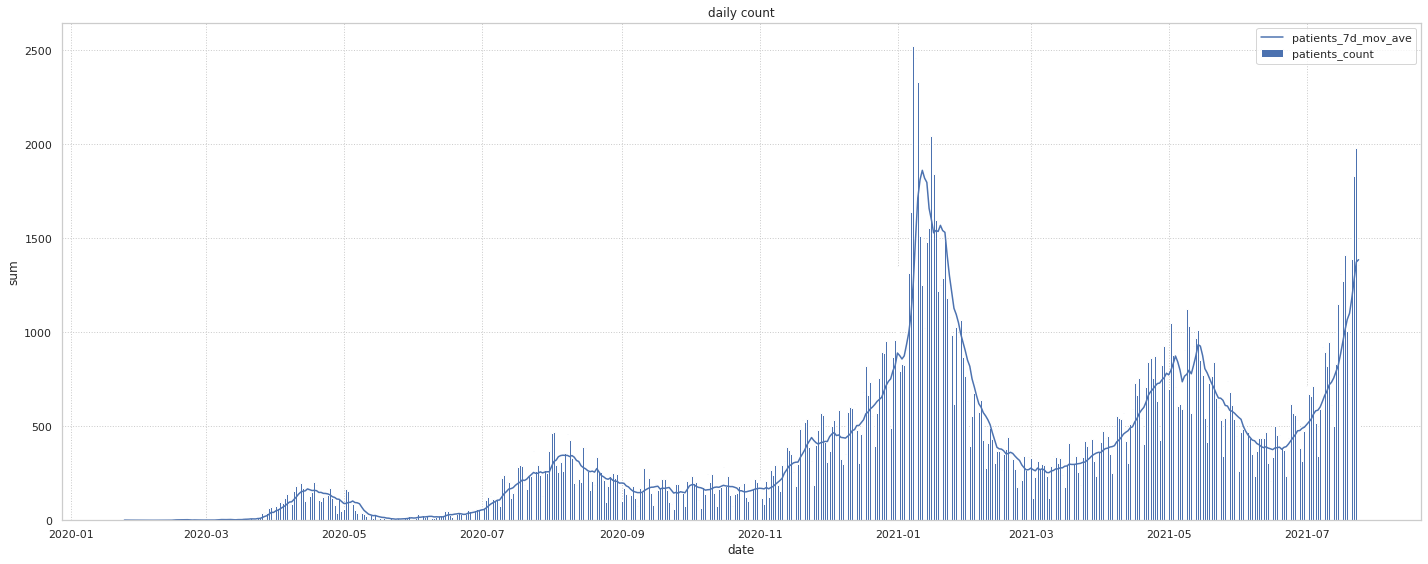

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
532,1.625818e+09,2021,7,9,1,0,0,0,0,0,0,532,0,458,504,436.142857,3053.0,0,0.0,0.0,822,686.714286,4807.0
533,1.625904e+09,2021,7,10,0,0,1,0,0,0,0,533,0,459,502,446.428571,3125.0,0,0.0,0.0,950,720.142857,5041.0
534,1.625990e+09,2021,7,11,0,0,0,1,0,0,0,534,0,460,403,453.285714,3173.0,0,0.0,0.0,614,733.857143,5137.0
535,1.626077e+09,2021,7,12,0,1,0,0,0,0,0,535,0,461,509,468.857143,3282.0,0,0.0,0.0,502,756.714286,5297.0
536,1.626163e+09,2021,7,13,0,0,0,0,0,1,0,536,0,462,518,480.571429,3364.0,0,0.0,0.0,830,790.571429,5534.0
537,1.626250e+09,2021,7,14,0,0,0,0,0,0,1,537,0,463,533,486.142857,3403.0,0,0.0,0.0,1149,823.285714,5763.0
538,1.626336e+09,2021,7,15,0,0,0,0,1,0,0,538,0,464,559,504.000000,3528.0,0,0.0,0.0,1308,882.142857,6175.0
539,1.626422e+09,2021,7,16,1,0,0,0,0,0,0,539,0,465,595,517.000000,3619.0,0,0.0,0.0,1271,946.285714,6624.0
540,1.626509e+09,2021,7,17,0,0,1,0,0,0,0,540,0,466,711,546.857143,3828.0,0,0.0,0.0,1410,1012.000000,7084.0
541,1.626595e+09,2021,7,18,0,0,0,1,0,0,0,541,0,467,526,564.428571,3951.0,0,0.0,0.0,1008,1068.285714,7478.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547 entries, 0 to 546
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            547 non-null    float64
 1   year                 547 non-null    int64  
 2   month                547 non-null    int64  
 3   day                  547 non-null    int64  
 4   Fri                  547 non-null    uint8  
 5   Mon                  547 non-null    uint8  
 6   Sat                  547 non-null    uint8  
 7   Sun                  547 non-null    uint8  
 8   Thu                  547 non-null    uint8  
 9   Tue                  547 non-null    uint8  
 10  Wed                  547 non-null    uint8  
 11  passed               547 non-null    int64  
 12  emergency            547 non-null    int64  
 13  em_passed            547 non-null    int64  
 14  contacts_count       547 non-null    int64  
 15  contacts_7d_mov_ave  547 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,5.470000e+02,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.00000,547.00000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000
mean,1.603440e+09,2020.372943,5.771481,15.705667,0.144424,0.142596,0.142596,0.142596,0.142596,0.142596,0.142596,273.00000,0.08958,204.073126,648.065814,645.216984,4516.511883,673.709324,673.709324,4715.965265,359.049360,350.696344,2454.844607
std,1.365548e+07,0.484030,3.182034,8.794730,0.351841,0.349980,0.349980,0.349980,0.349980,0.349980,0.349980,158.04957,0.28584,150.594336,424.329861,412.272829,2885.920730,857.320872,774.192365,5419.346556,389.047032,356.549769,2495.877702
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.591646e+09,2020.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,136.50000,0.00000,62.500000,373.500000,376.571429,2636.000000,0.000000,0.000000,0.000000,79.000000,94.500000,661.500000
50%,1.603440e+09,2020.000000,5.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,273.00000,0.00000,199.000000,517.000000,527.857143,3695.000000,0.000000,0.000000,0.000000,248.000000,258.142857,1807.000000
75%,1.615234e+09,2021.000000,8.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,409.50000,0.00000,335.500000,746.000000,734.285714,5140.000000,1312.500000,1307.357143,9151.500000,501.000000,485.571429,3399.000000
max,1.627027e+09,2021.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,546.00000,1.00000,472.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,2520.000000,1861.142857,13028.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.837599,0.104482,-0.009028,4.260251e-18,-0.001291,-0.006457,-0.003874,0.006457,0.001291,0.003874,1.000000e+00,-0.347637,0.996406,-0.322361,-0.313970,-0.313964,-0.566880,-0.611200,-0.611200,0.638465,0.674816,0.674829
year,8.375990e-01,1.000000,-0.453514,-0.044726,5.780278e-03,-0.000969,-0.000969,-0.000969,-0.000969,-0.000969,-0.000969,8.375990e-01,-0.241909,0.853061,-0.309905,-0.294719,-0.294716,-0.606589,-0.671721,-0.671721,0.611199,0.667164,0.667165
month,1.044816e-01,-0.453514,1.000000,-0.023874,-1.136455e-02,-0.000289,-0.008512,-0.005222,0.012868,0.004645,0.007934,1.044816e-01,-0.124448,0.070265,0.041743,0.027330,0.027334,0.181789,0.229552,0.229552,-0.074193,-0.118187,-0.118168
day,-9.028360e-03,-0.044726,-0.023874,1.000000,9.027620e-03,-0.000025,-0.003595,0.007115,-0.005975,-0.008355,0.001760,-9.028360e-03,-0.000421,-0.008144,-0.013352,-0.009837,-0.009841,0.011408,-0.001916,-0.001916,-0.002360,0.007405,0.007392
Fri,4.260251e-18,0.005780,-0.011365,0.009028,1.000000e+00,-0.167553,-0.167553,-0.167553,-0.167553,-0.167553,-0.167553,9.360903e-19,-0.001398,0.000976,-0.023532,-0.004172,-0.004171,0.029624,-0.003883,-0.003883,0.050591,0.005153,0.005146
Mon,-1.291323e-03,-0.000969,-0.000289,-0.000025,-1.675527e-01,1.000000,-0.166311,-0.166311,-0.166311,-0.166311,-0.166311,-1.291323e-03,0.000234,-0.001345,0.039081,-0.000019,-0.000018,0.132280,0.000651,0.000651,-0.143213,-0.003430,-0.003428
Sat,-6.456615e-03,-0.000969,-0.008512,-0.003595,-1.675527e-01,-0.166311,1.000000,-0.166311,-0.166311,-0.166311,-0.166311,-6.456615e-03,0.000234,-0.006001,0.045876,-0.002066,-0.002065,-0.151426,0.000651,0.000651,0.053551,-0.007060,-0.007066
Sun,-3.873969e-03,-0.000969,-0.005222,0.007115,-1.675527e-01,-0.166311,-0.166311,1.000000,-0.166311,-0.166311,-0.166311,-3.873969e-03,0.000234,-0.003673,-0.025308,-0.001112,-0.001111,-0.139468,0.000651,0.000651,-0.049377,-0.004952,-0.004952
Thu,6.456615e-03,-0.000969,0.012868,-0.005975,-1.675527e-01,-0.166311,-0.166311,-0.166311,1.000000,-0.166311,-0.166311,6.456615e-03,0.000234,0.005709,-0.001358,0.003996,0.003997,0.039009,0.000651,0.000651,0.091511,0.007466,0.007471
Tue,1.291323e-03,-0.000969,0.004645,-0.008355,-1.675527e-01,-0.166311,-0.166311,-0.166311,-0.166311,1.000000,-0.166311,1.291323e-03,0.000234,0.000983,-0.024162,0.001038,0.001039,0.053128,0.000651,0.000651,-0.034272,-0.000523,-0.000520


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,1.626682e+09,0,1,0,0,0,0,0,542,0,468,603,0,727,1100.428571,7703.0
543,1.626768e+09,0,0,0,0,0,1,0,543,0,469,583,0,1387,1180.000000,8260.0
544,1.626854e+09,0,0,0,0,0,0,1,544,0,470,724,0,1832,1277.571429,8943.0
545,1.626941e+09,0,0,0,0,1,0,0,545,0,471,907,0,1979,1373.428571,9614.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
542,1.626682e+09,542,0,727,1100.428571,7703.0
543,1.626768e+09,543,0,1387,1180.000000,8260.0
544,1.626854e+09,544,0,1832,1277.571429,8943.0
545,1.626941e+09,545,0,1979,1373.428571,9614.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

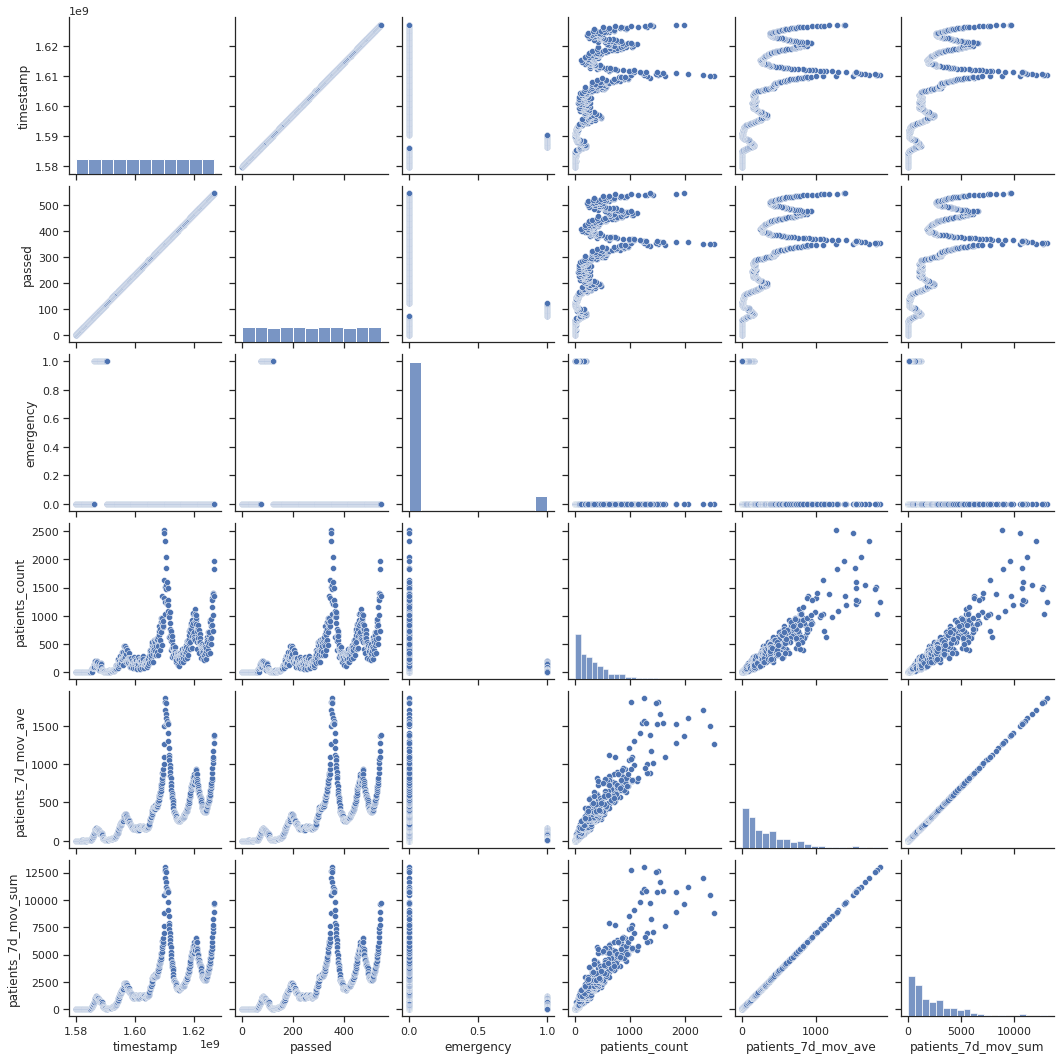

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.11
